In [1]:
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy
"""
import scanpy as sc
import harmonypy as hm
import pandas as pd

In [ ]:
# Convert h5 to h5AD
# NOTE: VERY SLOW, 10 minutes+
adata = sc.read_10x_h5('GSE178341_crc10x_full_c295v4_submit.h5')
adata.write_h5ad('GSE178341_crc10x_full_c295v4_submit.h5ad')

In [ ]:
adata = sc.read_h5ad("GSE178341_crc10x_full_c295v4_submit.h5ad")

In [ ]:
# Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# View QC metrics
print(adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head())

In [ ]:
# Define QC thresholds
min_genes = 200  # Cells must have at least 200 genes
max_genes = 5000  # Remove cells with very high gene counts
max_mt = 5  # Remove cells with >5% mitochondrial RNA

# Apply filtering
adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
adata = adata[adata.obs.pct_counts_mt < max_mt, :]

print(f"Remaining cells after filtering: {adata.n_obs}")

In [ ]:
# Filter Out Low-Quality Genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

In [ ]:
# Normalize & Log-Transform Data for downstream analysis
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify Highly Variable Genes
# Select genes that show high variability across cells
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print(f"Number of highly variable genes: {adata.shape[1]}")

In [ ]:
# Save the Processed Data
adata.write("GSE178341_QC.h5ad")

In [2]:
adata = sc.read_h5ad("GSE178341_QC.h5ad")

In [4]:
# Read metadata
metadata = pd.read_csv("GSE178341_crc10x_full_c295v4_submit_metatables.csv")
print(metadata.head())

                                   cellID SPECIMEN_TYPE SOURCE_HOSPITAL  \
0  C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT             T             MGH   
1  C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT             T             MGH   
2  C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG             T             MGH   
3  C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT             T             MGH   
4  C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC             T             MGH   

  TISSUE_PROCESSING_TEAM PROCESSING_TYPE SINGLECELL_TYPE PatientTypeID  \
0                Hacohen        unsorted          SC3Pv2        C103_T   
1                Hacohen        unsorted          SC3Pv2        C103_T   
2                Hacohen        unsorted          SC3Pv2        C103_T   
3                Hacohen        unsorted          SC3Pv2        C103_T   
4                Hacohen        unsorted          SC3Pv2        C103_T   

  HistologicTypeSimple    MMR_IHC MMRStatus  ... NodeStatus_detailed  \
0       Adenocarcinoma  preserve

In [5]:
if 'MMRStatus' not in adata.obs.columns:
    # Import the MMR Statuses (merge in the metadata by matching the cell IDs)
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.merge(metadata[['cellID', 'MMRStatus']], left_on='index', right_on='cellID', how='left')
    adata.obs = adata.obs.set_index('index')

    # Clean up duplicate column after merge
    adata.obs.drop(columns=['cellID'], inplace=True)

In [6]:
# Check counts of MMRd vs. MMRp
print(adata.obs["MMRStatus"].value_counts())  

MMRStatus
MMRp    37076
MMRd    29365
Name: count, dtype: int64


In [7]:
"""
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0] # Patient IDs
adata.obs["region"] = obs_names.str[1] # Sample Regions
print(adata.obs["batch"].value_counts())  # Number of cells per patient sample

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64


In [9]:
# Separate dataset into MMRp, MMRd, and isolate tumor cells
adata_MMRp = adata[adata.obs['MMRStatus'] == 'MMRp'].copy()
adata_MMRd = adata[adata.obs['MMRStatus'] == 'MMRd'].copy()
adata_tumor = adata[adata.obs['region'] == 'T'].copy()

In [10]:
# Perform PCA and clustering 
# For MMRp
sc.tl.pca(adata_MMRp, svd_solver='arpack')
sc.pp.neighbors(adata_MMRp, n_neighbors=10, n_pcs=40)

# For MMRd
sc.tl.pca(adata_MMRd, svd_solver='arpack')
sc.pp.neighbors(adata_MMRd, n_neighbors=10, n_pcs=40)

# For Tumor Cells
sc.tl.pca(adata_tumor, svd_solver='arpack')
sc.pp.neighbors(adata_tumor, n_neighbors=10, n_pcs=40)

/Users/rosiepham/Desktop/BENG204/Group Project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
# Run Harmony for batch correction
adata_MMRp.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRp.obsm["X_pca"], adata_MMRp.obs, 'batch').Z_corr.T # transpose result to fit expected shape
adata_MMRd.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRd.obsm["X_pca"], adata_MMRd.obs, 'batch').Z_corr.T
adata_tumor.obsm["X_pca_harmony"] = hm.run_harmony(adata_tumor.obsm["X_pca"], adata_tumor.obs, 'batch').Z_corr.T

2025-03-09 22:34:44,868 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-09 22:35:01,508 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-09 22:35:01,840 - harmonypy - INFO - Iteration 1 of 10
2025-03-09 22:35:23,056 - harmonypy - INFO - Iteration 2 of 10
2025-03-09 22:35:49,007 - harmonypy - INFO - Iteration 3 of 10
2025-03-09 22:36:11,355 - harmonypy - INFO - Iteration 4 of 10
2025-03-09 22:36:20,895 - harmonypy - INFO - Iteration 5 of 10
2025-03-09 22:36:30,761 - harmonypy - INFO - Converged after 5 iterations
2025-03-09 22:36:30,817 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-09 22:36:44,154 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-09 22:36:44,586 - harmonypy - INFO - Iteration 1 of 10
2025-03-09 22:37:01,233 - harmonypy - INFO - Iteration 2 of 10
2025-03-09 22:37:18,463 - harmonypy - INFO - Iteration 3 of 10
2025-03-09 22:37:34,086 - harmonypy - INFO - Iteration 4 of 

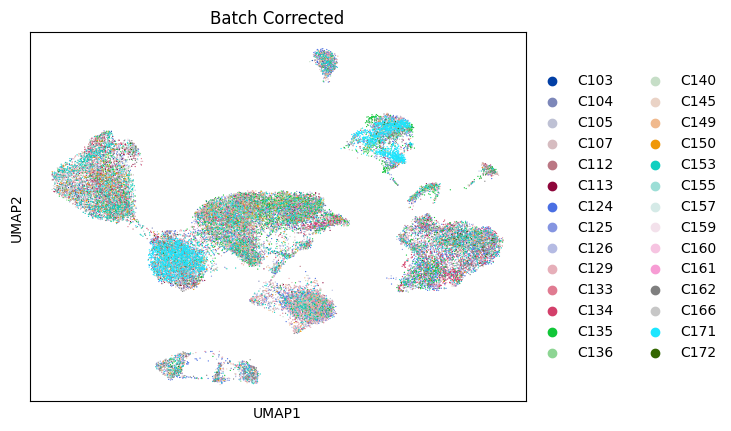

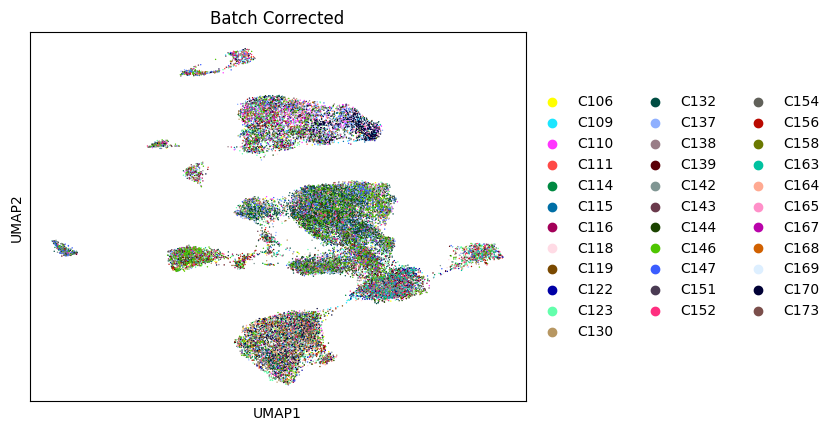

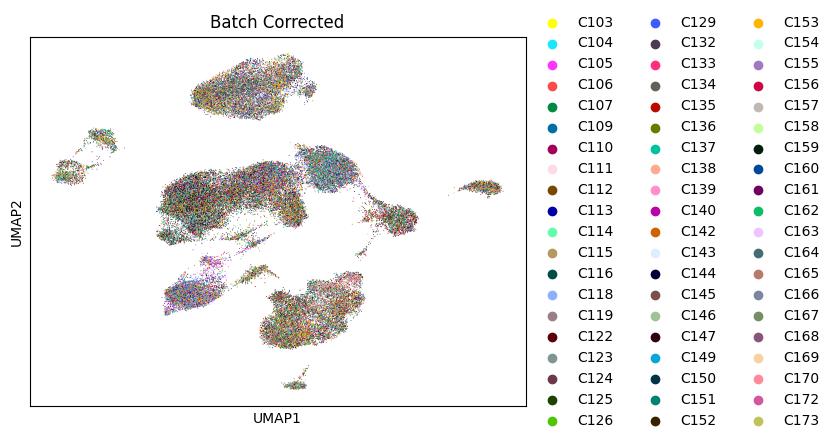

In [30]:
# Update neighbors & recompute UMAP
sc.pp.neighbors(adata_MMRp, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color="batch", title="MMRp: Batch Corrected")

sc.pp.neighbors(adata_MMRd, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color="batch", title="MMRd: Batch Corrected")

sc.pp.neighbors(adata_tumor, use_rep="X_pca_harmony")
sc.tl.umap(adata_tumor)
sc.pl.umap(adata_tumor, color="batch", title="Tumor Cells: Batch Corrected")

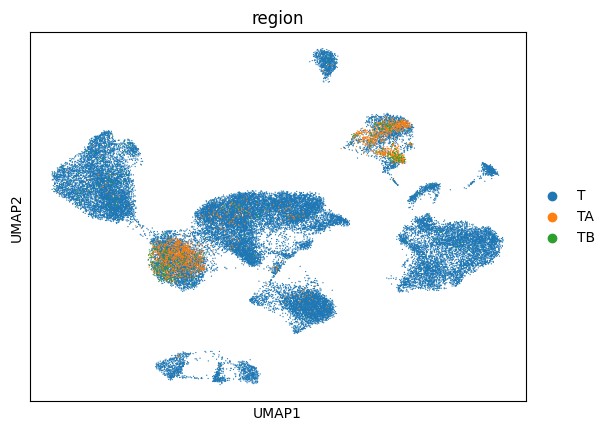

In [ ]:
# Verify Teal Cluster is due to Biological Variation not Leftover Batch Effects
sc.pl.umap(adata_MMRp, color=['region'])


In [31]:
# Leiden clustering 
sc.tl.leiden(adata_MMRp, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)
sc.tl.leiden(adata_MMRd, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)
sc.tl.leiden(adata_tumor, resolution=0.5, flavor="igraph", n_iterations=2, directed=False)

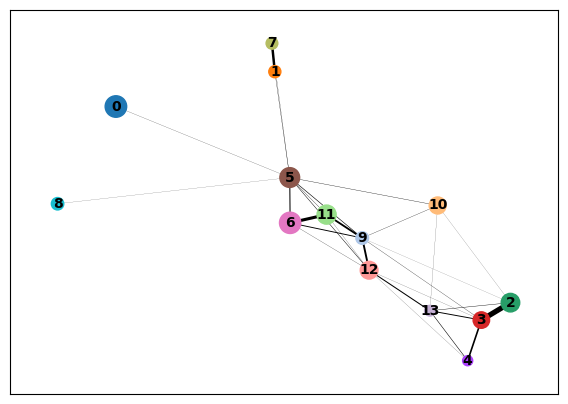

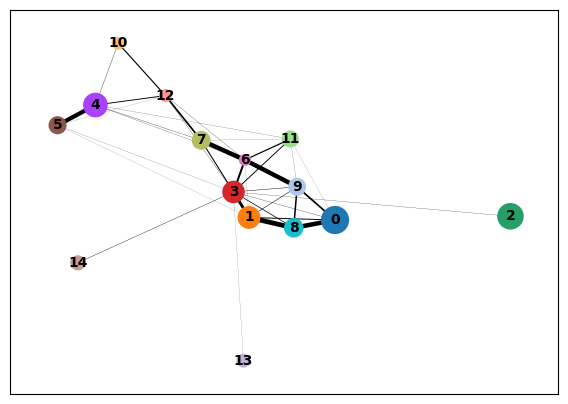

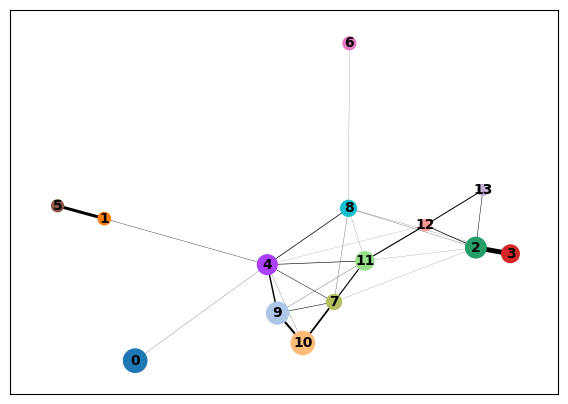

In [33]:
# Run PAGA for RNA Trajectory Analysis
sc.tl.paga(adata_MMRp, groups='leiden')
sc.tl.paga(adata_MMRd, groups='leiden')
sc.tl.paga(adata_tumor, groups='leiden')

# Plot PAGA Graph
sc.pl.paga(adata_MMRp, color=['leiden'])
sc.pl.paga(adata_MMRd, color=['leiden'])
sc.pl.paga(adata_tumor, color=['leiden'])

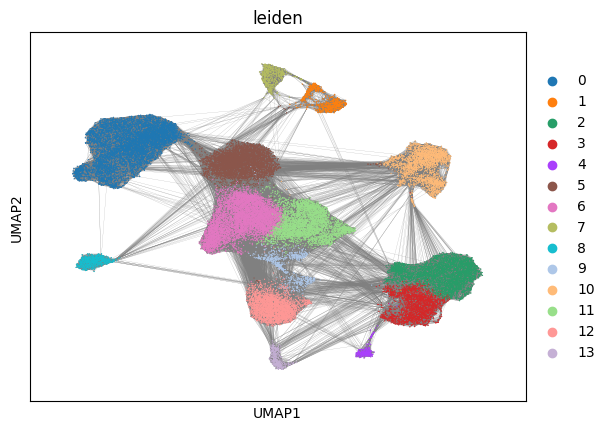

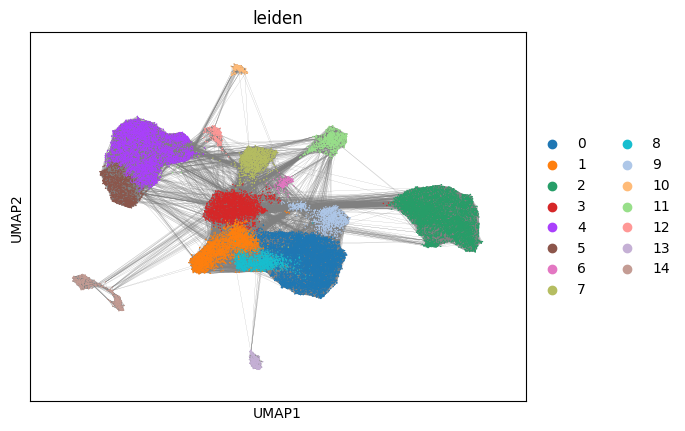

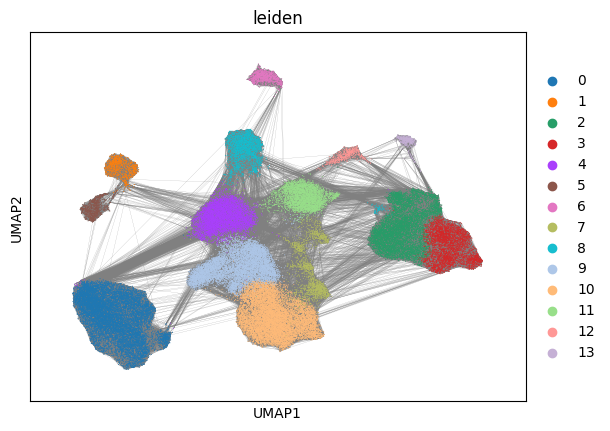

In [34]:
sc.tl.umap(adata_MMRp, init_pos='paga')
sc.tl.umap(adata_MMRd, init_pos='paga')
sc.tl.umap(adata_tumor, init_pos='paga')

sc.pl.umap(adata_MMRp, color=['leiden'], edges=True)
sc.pl.umap(adata_MMRd, color=['leiden'], edges=True)
sc.pl.umap(adata_tumor, color=['leiden'], edges=True)

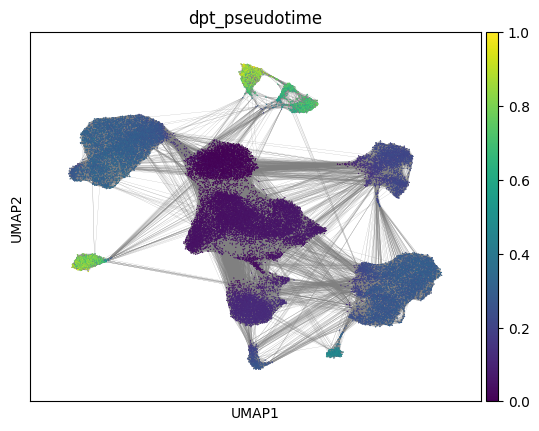

In [ ]:
# Pick root cluster number (TODO NEED HELP TO CHOOSE FROM TA)
root_cluster_MMRp = '5'  
# Find a cell index in that cluster to set as root
root_cell_index_MMRp = adata_MMRp.obs.query('leiden == @root_cluster_MMRp').index[0]
# Assign the root cell
adata_MMRp.uns['iroot'] = adata_MMRp.obs_names.get_loc(root_cell_index_MMRp)
# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRp)
# Create new UMAP
sc.pl.umap(adata_MMRp, color='dpt_pseudotime', edges=True)

# Pick root cluster number (TODO NEED HELP TO CHOOSE FROM TA)
root_cluster_MMRd = '5'  
# Find a cell index in that cluster to set as root
root_cell_index_MMRd = adata_MMRd.obs.query('leiden == @root_cluster_MMRd').index[0]
# Assign the root cell
adata_MMRd.uns['iroot'] = adata_MMRd.obs_names.get_loc(root_cell_index_MMRd)
# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRd)
# Create new UMAP
sc.pl.umap(adata_MMRd, color='dpt_pseudotime', edges=True)

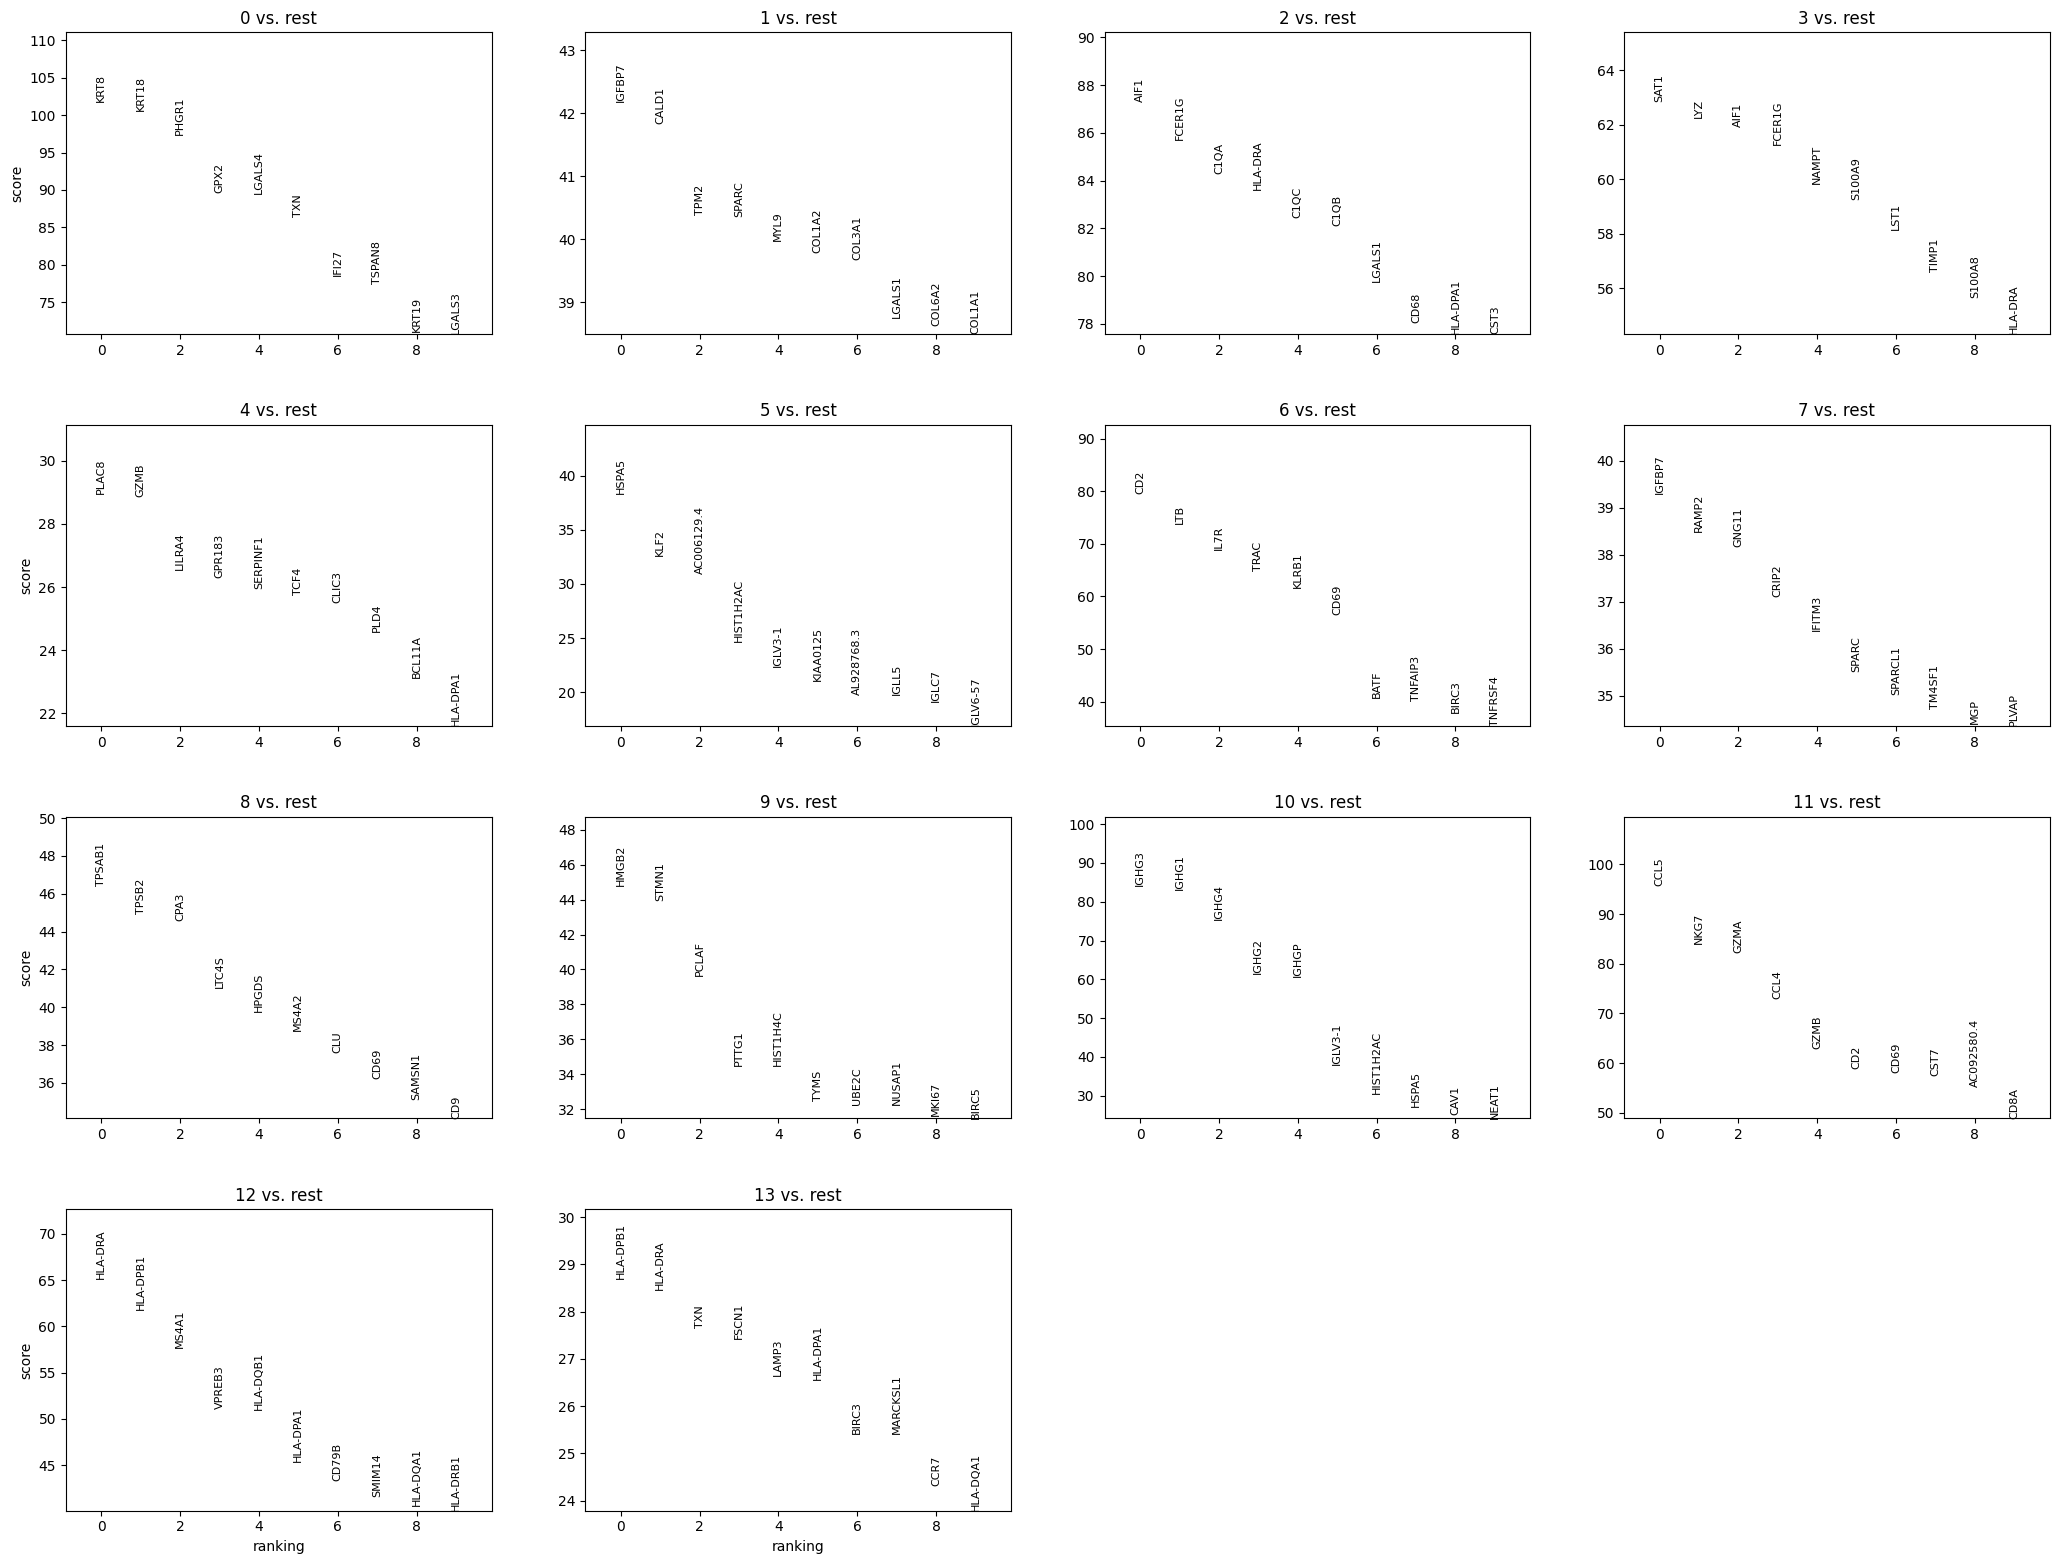

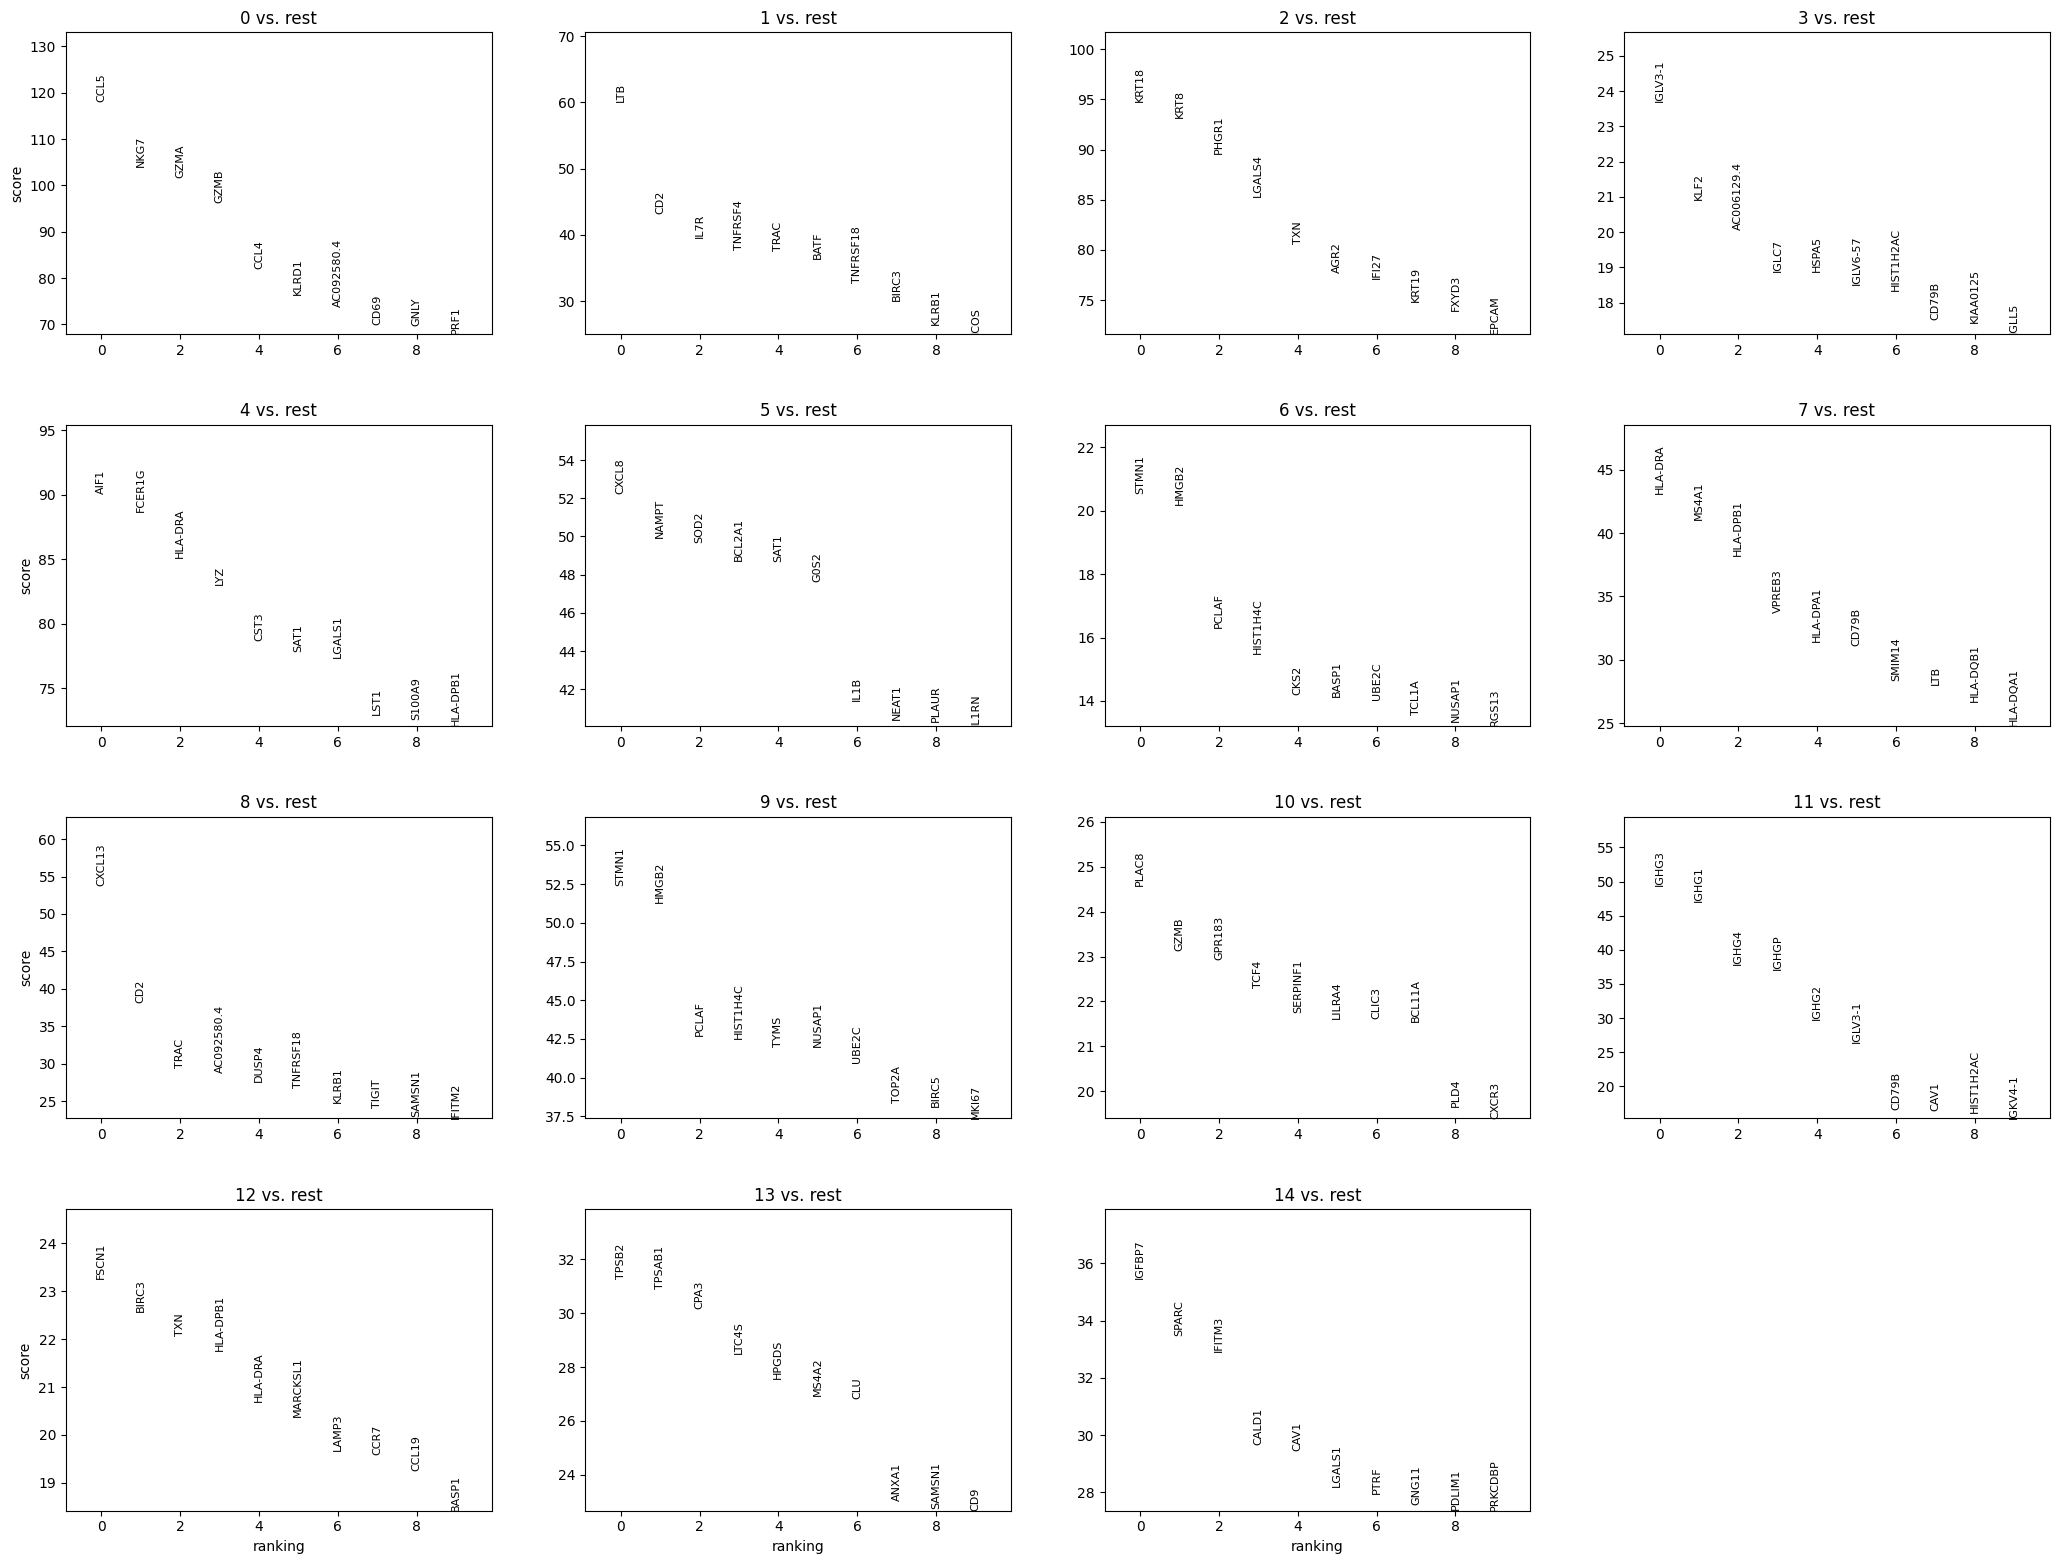

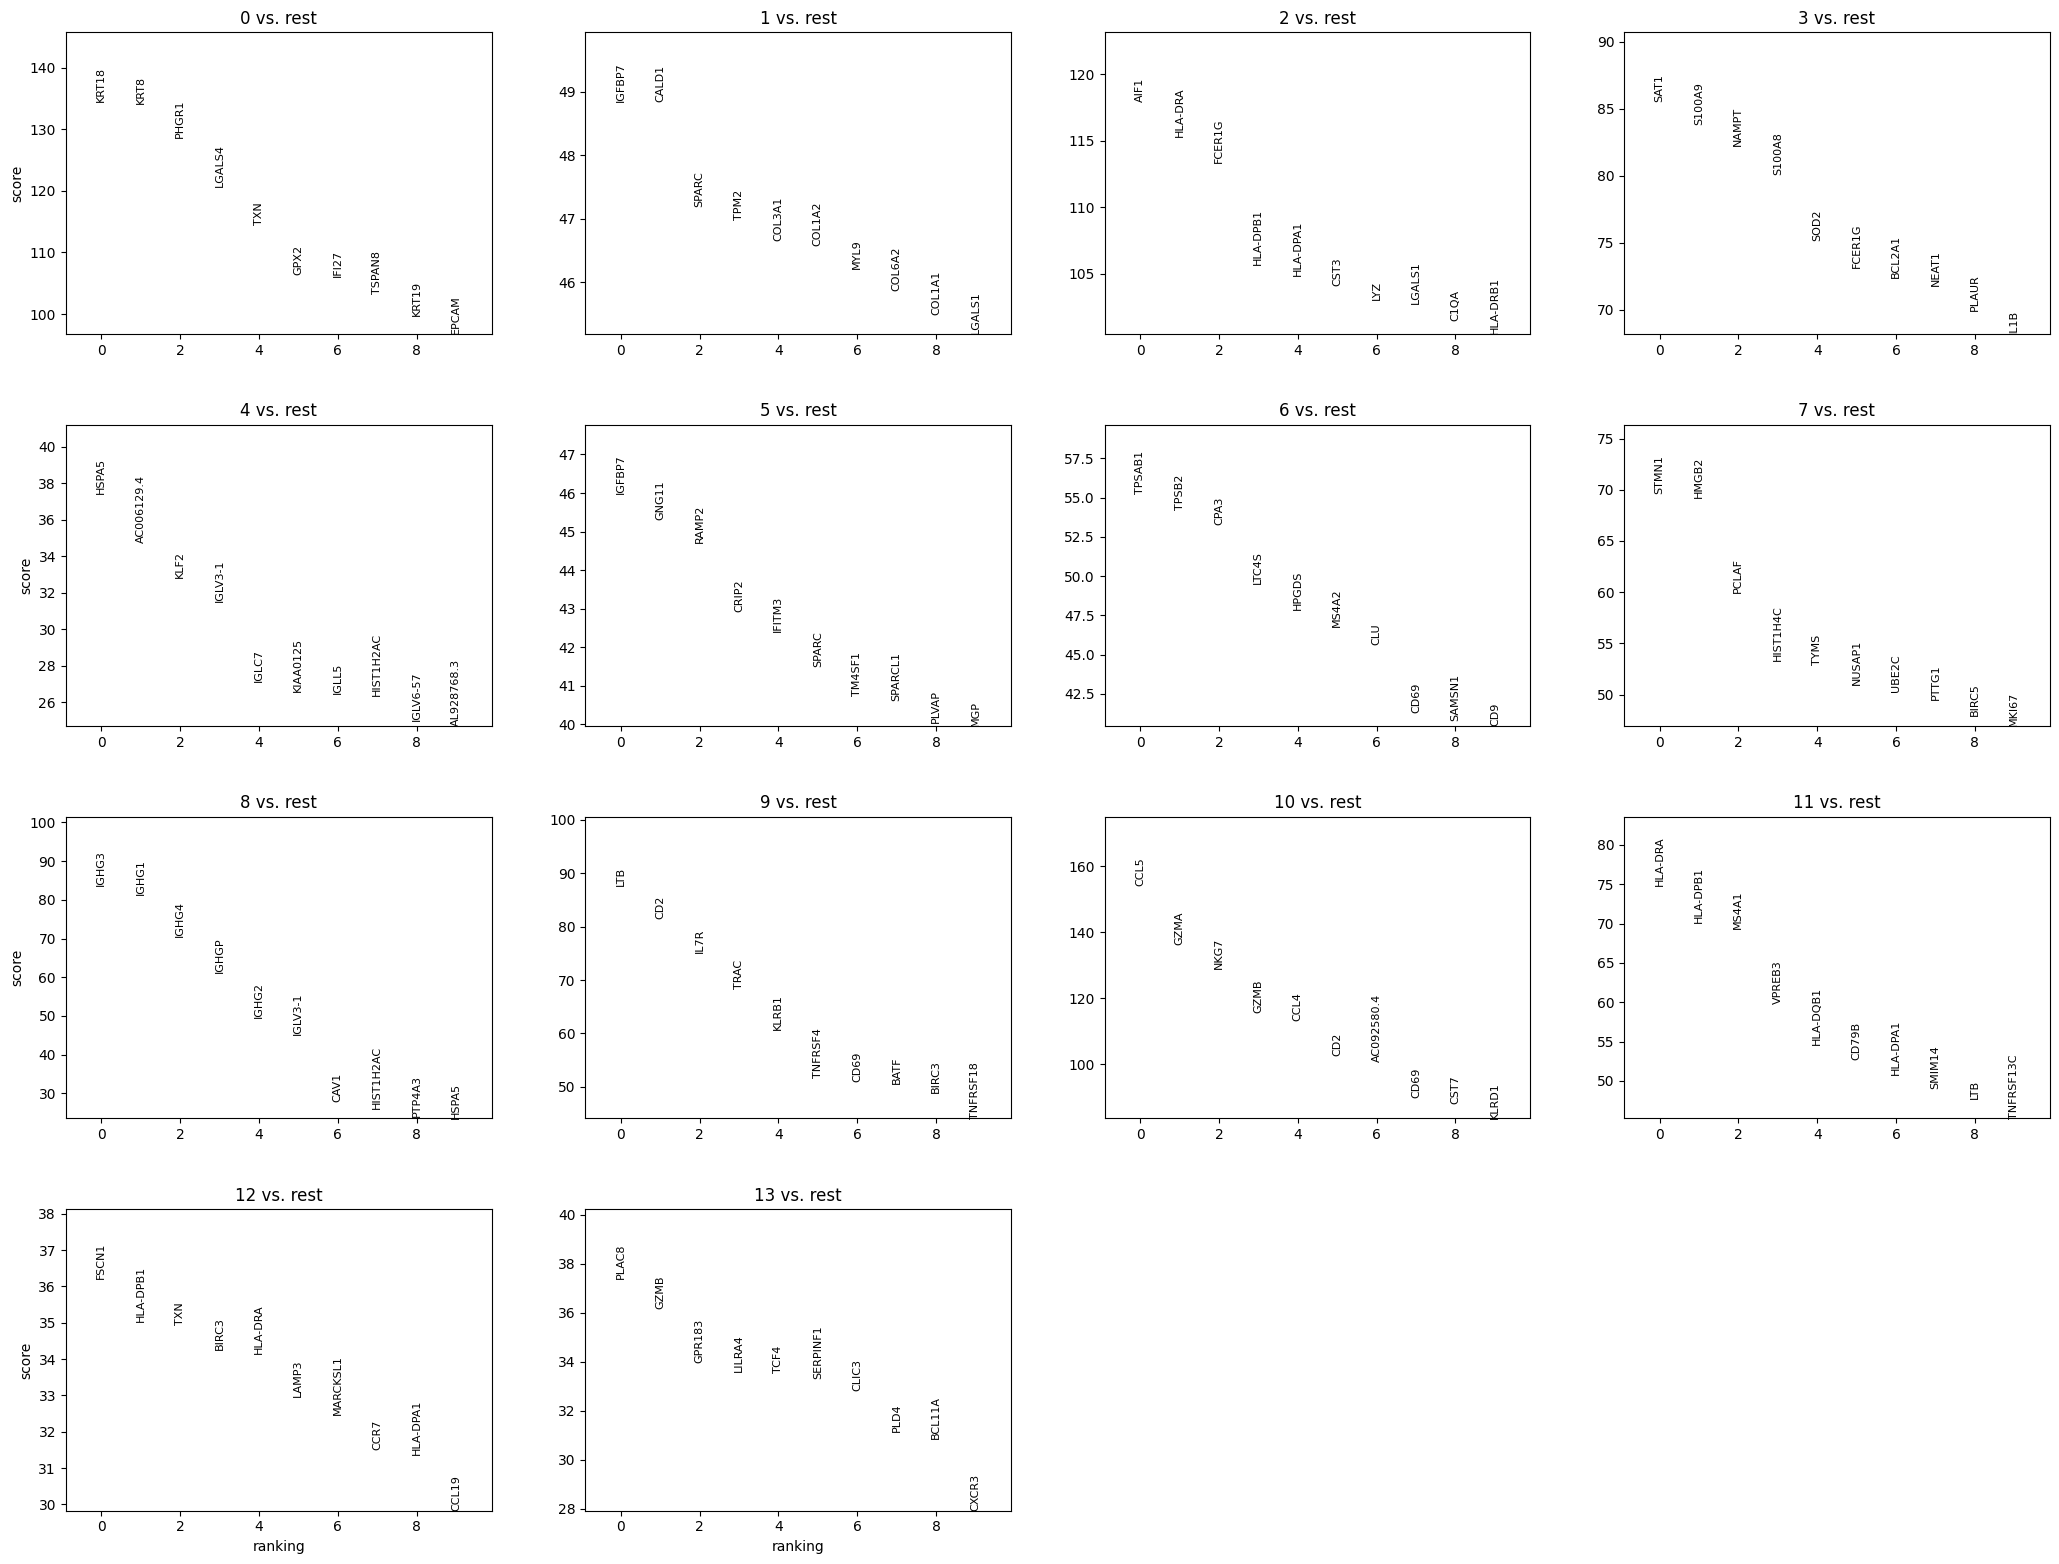

In [35]:
# Find the top-expressed genes in each cluster
sc.tl.rank_genes_groups(adata_MMRp, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_MMRp, n_genes=10, sharey=False)

sc.tl.rank_genes_groups(adata_MMRd, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_MMRd, n_genes=10, sharey=False)

sc.tl.rank_genes_groups(adata_tumor, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_tumor, n_genes=10, sharey=False)

In [36]:
print(adata_MMRp.uns['rank_genes_groups'])

{'params': {'groupby': 'leiden', 'reference': 'rest', 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('KRT8', 'IGFBP7', 'AIF1', 'SAT1', 'PLAC8', 'HSPA5', 'CD2', 'IGFBP7', 'TPSAB1', 'HMGB2', 'IGHG3', 'CCL5', 'HLA-DRA', 'HLA-DPB1'),
           ('KRT18', 'CALD1', 'FCER1G', 'LYZ', 'GZMB', 'KLF2', 'LTB', 'RAMP2', 'TPSB2', 'STMN1', 'IGHG1', 'NKG7', 'HLA-DPB1', 'HLA-DRA'),
           ('PHGR1', 'TPM2', 'C1QA', 'AIF1', 'LILRA4', 'AC006129.4', 'IL7R', 'GNG11', 'CPA3', 'PCLAF', 'IGHG4', 'GZMA', 'MS4A1', 'TXN'),
           ...,
           ('HLA-DPA1', 'HLA-DRB1', 'BIRC3', 'TRAC', 'CEBPB', 'SAT1', 'LGALS1', 'LTB', 'LTB', 'TIMP1', 'IFITM3', 'TIMP1', 'CST3', 'CTSD'),
           ('NEAT1', 'HLA-DRA', 'CD2', 'CD2', 'TIMP1', 'IFITM2', 'HLA-DRA', 'GPR183', 'HLA-DPB1', 'IFITM3', 'HLA-DPB1', 'GRN', 'LGALS3', 'KLF2'),
           ('LGALS1', 'CD69', 'CD69', 'KRT18', 'LGALS3', 'HLA-DPB1', 'CST3', 'CD69', 'HLA-DRA', 'CST3', 'IFITM2', 'CST3', 'TXN'

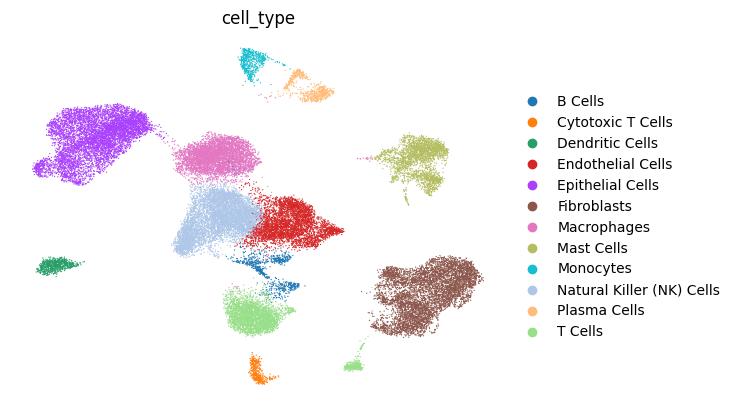

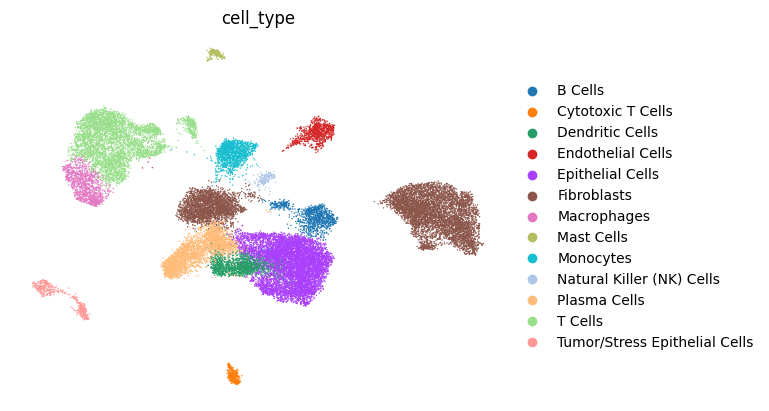

In [ ]:
# Define cluster labels based on marker genes (from above) (TODO FIX CLUSTER LABELS)
cluster_labels_MMRp = {
    "0": "Fibroblasts",
    "1": "T Cells",
    "2": "Macrophages",
    "3": "Tumor Epithelial Cells",
    "4": "Cytotoxic T Cells",
    "5": "Plasma Cells",
    "6": "B Cells",
    "7": "Macrophages",
    "8": "Mast Cells",
    "9": "Tumor Stem-Like Cells",
    "10": "Fibroblasts",
    "11": "Dendritic Cells",
    "12": "Dendritic Cells",
    "13": "Fibroblasts",
    "14": "Macrophages"
}



cluster_labels_MMRd = {
    "0": "Cytotoxic T Cells",
    "1": "T Cells",
    "2": "Monocytes",
    "3": "Plasma Cells",
    "4": "Monocytes (Classical)",
    "5": "Macrophages (Tumor-Associated)",
    "6": "Monocytes (Classical)",
    "7": "Dendritic Cells",
    "8": "Macrophages (Stress-Responsive)",
    "9": "Macrophages (Anti-inflammatory)",
    "10": "Fibroblasts (CAFs)",
    "11": "Dendritic Cells (APCs)",
    "12": "Follicular Dendritic Cells",
    "13": "Mast Cells",
    "14": "Interferon-Responsive Immune Cells"
}


cluster_labels_tumor = {
    "0": "Epithelial Cells",
    "1": "Plasma Cells",
    "2": "Fibroblasts",
    "3": "Fibroblasts",
    "4": "T Cells",
    "5": "Macrophages",
    "6": "Natural Killer (NK) Cells",
    "7": "Monocytes",
    "8": "Dendritic Cells",
    "9": "B Cells",
    "10": "Mast Cells",
    "11": "Endothelial Cells",
    "12": "T Cells",
    "13": "Cytotoxic T Cells",
    "14": "Tumor/Stress Epithelial Cells"
}

# Map cell type labels to leiden clusters
adata_MMRp.obs["cell_type"] = adata_MMRp.obs["leiden"].map(cluster_labels)
adata_MMRd.obs["cell_type"] = adata_MMRd.obs["leiden"].map(cluster_labels)
adata_tumor.obs["cell_type"] = adata_MMRd.obs["leiden"].map(cluster_labels)

# Visualize UMAP with new labels
sc.pl.umap(adata_MMRp, color="cell_type", frameon=False)
sc.pl.umap(adata_MMRd, color="cell_type", frameon=False)
sc.pl.umap(adata_tumor, color="cell_type", frameon=False)


In [ ]:
# Rank genes by cell type (leiden cluster)
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon")

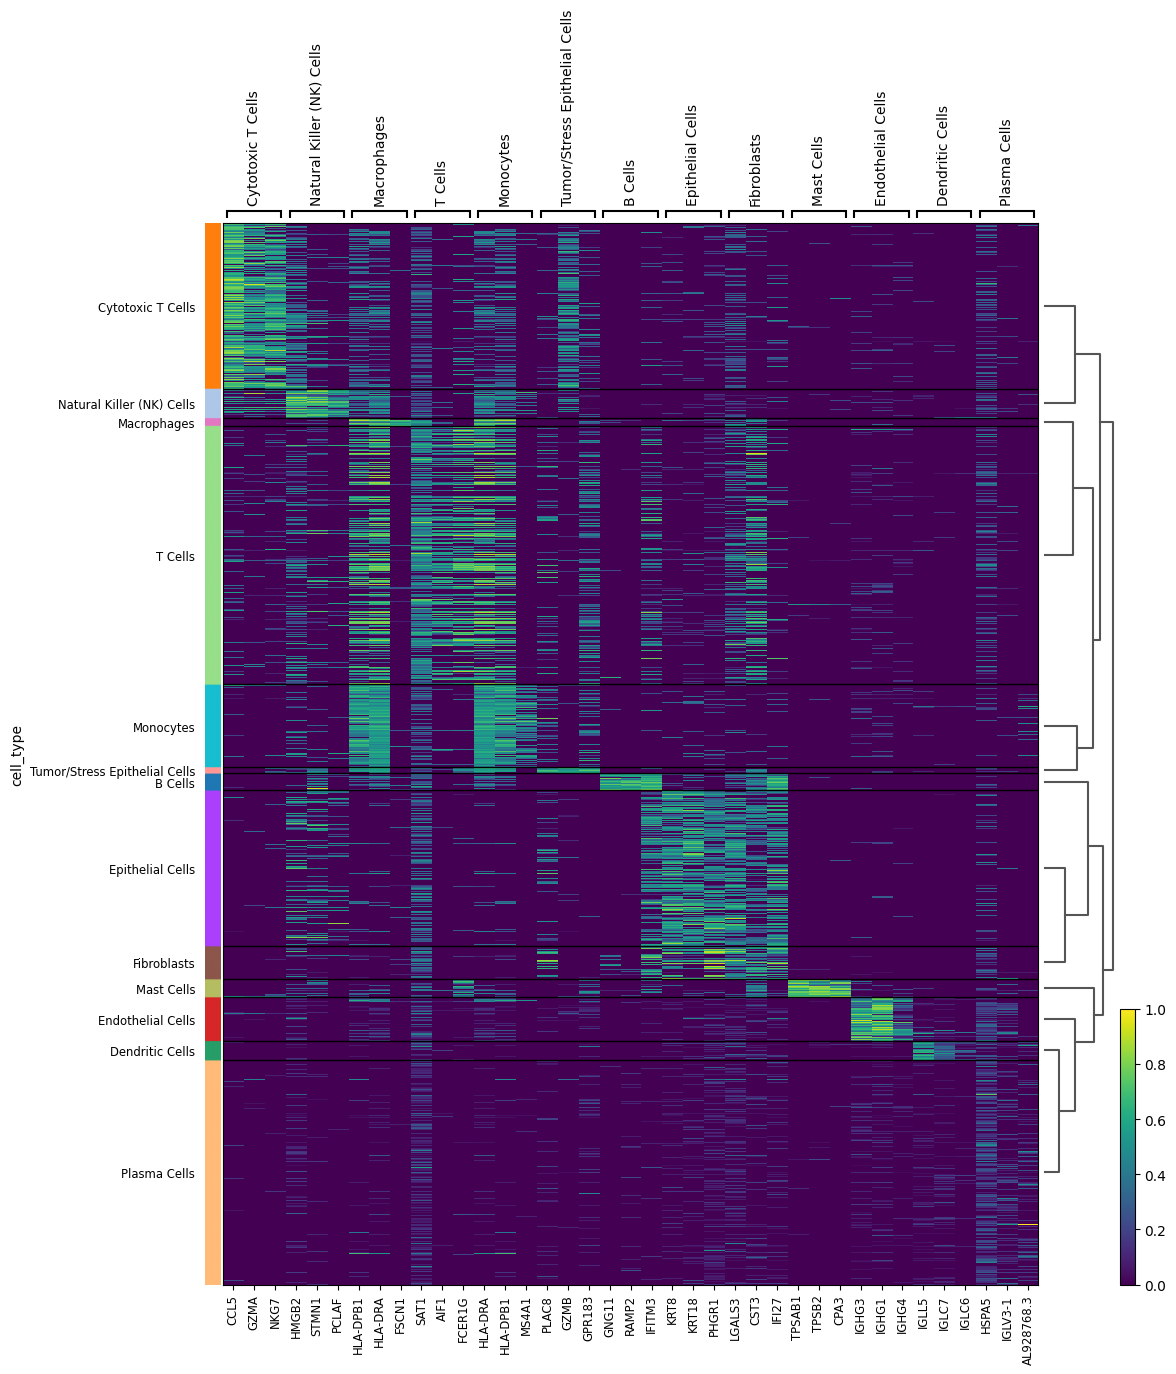

In [ ]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=3,
    groupby="cell_type",
    cmap="viridis",
    standard_scale="var",
    figsize=(12, 14),
)